In [36]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack,coo_matrix
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import TimeSeriesSplit

from bs4 import BeautifulSoup
from sklearn.linear_model import Lasso, LassoCV

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score

In [97]:
%matplotlib inline

In [5]:
PATH_TO_DATA = './data/Medium/traintestunsorted' 

In [106]:
%%time
tfidf_title = TfidfVectorizer(ngram_range=(1,2),max_features=50000)

with open('train_titles.txt',encoding="utf8") as train_content:
    X_train_title_sparse = tfidf_title.fit_transform(train_content)

with open('test_titles.txt',encoding="utf8") as test_content:
    X_test_title_sparse = tfidf_title.transform(test_content)

Wall time: 4.52 s


In [110]:
%%time
tfidf_content = TfidfVectorizer(ngram_range=(1,2),max_features=100000,min_df=0.1)

with open(os.path.join(PATH_TO_DATA,'train_content.txt'),encoding="utf8") as train_content:
    X_train_content_sparse = tfidf_content.fit_transform(train_content)

with open(os.path.join(PATH_TO_DATA,'test_content.txt'),encoding="utf8") as test_content:
    X_test_content_sparse = tfidf_content.transform(test_content)

Wall time: 9min 27s


In [123]:
from scipy import sparse

sparse.save_npz("./data/medium/X_test_content_sparse_bigram_correct.npz", X_test_content_sparse)
X_test_content_sparse = sparse.load_npz("./data/medium/X_test_content_sparse_bigram_correct.npz")

sparse.save_npz("./data/medium/X_train_content_sparse_bigram_correct.npz", X_train_content_sparse)
X_train_content_sparse = sparse.load_npz("./data/medium/X_train_content_sparse_bigram_correct.npz")

In [111]:
X_train_content_sparse.shape,X_test_content_sparse.shape

((62313, 1471), (34645, 1471))

In [108]:
%%time
tfidf_tags = TfidfVectorizer(ngram_range=(1,2),max_features=50000)

with open(os.path.join(PATH_TO_DATA,'train_tags.txt'),encoding="utf8") as train_content:
    X_train_tags_sparse = tfidf_tags.fit_transform(train_content)

with open(os.path.join(PATH_TO_DATA,'test_tags.txt'),encoding="utf8") as test_content:
    X_test_tags_sparse = tfidf_tags.transform(test_content)

Wall time: 1.93 s


In [112]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [113]:
X_train_sparse = hstack([X_train_content_sparse,X_train_tags_sparse,X_train_title_sparse]).tocsr()
X_test_sparse = hstack([X_test_content_sparse,X_test_tags_sparse,X_test_title_sparse]).tocsr()

In [114]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [115]:
ridge = Ridge(random_state=17)

In [116]:
%%time
ridge.fit(X_train_part, np.log1p(y_train_part));
ridge_pred = np.expm1(ridge.predict(X_valid))

Wall time: 10.3 s


In [16]:
# !pip install lightgbm

### XBM

In [124]:
import lightgbm as lgb

In [80]:
lgb_x_train_part = lgb.Dataset(X_train_part.astype(np.float32), label=np.log1p(y_train_part))

lgb_x_valid = lgb.Dataset(X_valid.astype(np.float32), label=np.log1p(y_valid))

In [81]:
param = {'num_leaves': 31, 'num_trees': 100, 'objective': 'mean_absolute_error',
        'metric': 'mae'}

In [82]:
num_round = 100
bst_lgb = lgb.train(param, lgb_x_train_part, num_round, valid_sets=[lgb_x_valid], early_stopping_rounds=20)

C:\Users\h213139\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 0.383812
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 0.380463
[3]	valid_0's l1: 0.377526
[4]	valid_0's l1: 0.375025
[5]	valid_0's l1: 0.37299
[6]	valid_0's l1: 0.37136
[7]	valid_0's l1: 0.369958
[8]	valid_0's l1: 0.368687
[9]	valid_0's l1: 0.367477
[10]	valid_0's l1: 0.366351
[11]	valid_0's l1: 0.36536
[12]	valid_0's l1: 0.3645
[13]	valid_0's l1: 0.363846
[14]	valid_0's l1: 0.362997
[15]	valid_0's l1: 0.362376
[16]	valid_0's l1: 0.361708
[17]	valid_0's l1: 0.361195
[18]	valid_0's l1: 0.360772
[19]	valid_0's l1: 0.360342
[20]	valid_0's l1: 0.359946
[21]	valid_0's l1: 0.359723
[22]	valid_0's l1: 0.359495
[23]	valid_0's l1: 0.359159
[24]	valid_0's l1: 0.358936
[25]	valid_0's l1: 0.358572
[26]	valid_0's l1: 0.358414
[27]	valid_0's l1: 0.358068
[28]	valid_0's l1: 0.357789
[29]	valid_0's l1: 0.357521
[30]	valid_0's l1: 0.357229
[31]	valid_0's l1: 0.357035
[32]	valid_0's l1: 0.356822
[33]	valid_0's l1: 0.356586
[34]	valid_0's l1: 0.356472


In [83]:
lgb_pred = np.expm1(bst_lgb.predict(X_valid.astype(np.float32),num_iteration=bst_lgb.best_iteration))

### Accuracy

In [84]:
ridge_valid_mae = mean_absolute_error(y_valid, ridge_pred)
ridge_valid_mae

1.2416306111271085

In [70]:
ridge_valid_mae = mean_absolute_error(y_valid, ridge_pred)
ridge_valid_mae

1.3591954788378717

In [85]:
lgb_valid_mae = mean_absolute_error(y_valid, lgb_pred)
lgb_valid_mae

1.2986755816955775

In [71]:
lgb_valid_mae = mean_absolute_error(y_valid, lgb_pred)
lgb_valid_mae

1.3003713117467555

In [86]:
mean_absolute_error(y_valid, .6 * lgb_pred + .4 * ridge_pred)

1.2524008803758988

In [72]:
mean_absolute_error(y_valid, .6 * lgb_pred + .4 * ridge_pred)

1.2699169814666293

In [119]:
ridge_valid_mae = mean_absolute_error(y_valid, ridge_pred)
ridge_valid_mae

1.1898277153303745

In [ ]:
lgb_valid_mae = mean_absolute_error(y_valid, lgb_pred)
mean_absolute_error(y_valid, .6 * lgb_pred + .4 * ridge_pred), ridge_valid_mae, lgb_valid_mae

### fit both model/Blending

In [120]:
%%time
ridge.fit(X_train_sparse, np.log1p(y_train));
ridge_test_pred = np.expm1(ridge.predict(X_test_sparse))

Wall time: 17.1 s


In [125]:
lgb_x_train = lgb.Dataset(X_train_sparse.astype(np.float32),
                          label=np.log1p(y_train))

num_round = 100
bst_lgb = lgb.train(param, lgb_x_train, num_round)

lgb_test_pred = np.expm1(bst_lgb.predict(X_test_sparse.astype(np.float32)))

C:\Users\h213139\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [126]:
mix_pred = .6 * lgb_test_pred + .4 * ridge_test_pred
mix_pred_adjusted = mix_pred+ (4.33328 -mix_pred.mean())
mix_pred_adjusted.mean(),mix_pred.mean()

(4.333279999999999, 2.942546384637172)

In [121]:
# ridge_test_pred_adjusted = ridge_test_pred+ (4.33328 -ridge_test_pred.mean())

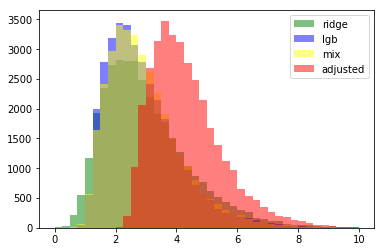

In [127]:
import matplotlib.pyplot as plt
plt.hist(ridge_test_pred, bins=40, alpha=.5, color='green', label='ridge', range=(0,10));
plt.hist(lgb_test_pred, bins=40, alpha=.5, color='blue', label='lgb', range=(0,10));
plt.hist(mix_pred, bins=40, alpha=.5, color='yellow', label='mix', range=(0,10));
plt.hist(mix_pred_adjusted, bins=40, alpha=.5, color='red', label='adjusted', range=(0,10));
plt.legend()

### Submission

In [93]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [33]:
write_submission_file(mix_pred_adjusted, './assignment6_submissions/medium_submission_9.csv')
#CV 1.1183674864649338 LB# 1.78865

In [94]:
write_submission_file(mix_pred_adjusted, './assignment6_submissions/medium_submission_10.csv')
#CV 1.1183674864649338 LB# 1.78865

In [128]:
write_submission_file(mix_pred_adjusted, './assignment6_submissions/assignment6_medium_submission_adjusted_15.csv')
#LB

In [52]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [56]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

In [53]:
def preprocess(path_to_inp_json_file, path_to_out_txt_file):
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            out_file.write(content_no_html_tags + '\n')

In [57]:
%%time
preprocess(path_to_inp_json_file=os.path.join('./data/Medium/', 'train.json'),
           path_to_out_txt_file='train_titles.txt')


Wall time: 38.5 s


In [58]:
%%time
preprocess(path_to_inp_json_file=os.path.join('./data/Medium/', 'test.json'),
           path_to_out_txt_file='test_titles.txt')


Wall time: 23.9 s
